## Modelo 1

código de:
- <https://www.bayesianmodelsforastrophysicaldata.com/code-4-7>
- <https://github.com/astrobayes/BMAD/blob/master/chapter_4/code_4.7.py>

O codigo abaixo usa uma regressão pra cada coordenada do centro de massa do dataframe livro.csv.

É necessário uma estimativa da variância do modelo. Isso se encontra no notebook que gera os dados usados em cada regressão abaixo.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# pra fazer os negócios funcionar
import nest_asyncio
nest_asyncio.apply()

# pra sumir com os warnings
import warnings
warnings.filterwarnings('ignore')  # não deu certo :(

In [3]:
livro = pd.read_csv('data/livro.csv')
livro

,intern_clock,1,2,3,4,x,y
0,31032,0.0,0.0,0.0,0.0,39.805067,-17.093603
1,31130,0.0,0.0,0.0,0.0,31.603003,-15.421540
2,31227,0.0,0.0,0.0,0.0,33.888520,-19.008985
3,31326,0.0,0.0,0.0,0.0,35.133377,-20.662502
4,31424,0.0,0.0,0.0,0.0,26.759043,-16.759596
...,...,...,...,...,...,...,...
699,99546,0.0,0.0,0.0,0.0,19.244610,26.384993
700,99643,0.0,0.0,0.0,0.0,19.725827,27.399102
701,99741,0.0,0.0,0.0,0.0,18.731329,28.161931
702,99840,0.0,0.0,0.0,0.0,18.748916,27.735171


In [4]:
# From: Bayesian Models for Astrophysical Data, Cambridge Univ. Press
# (c) 2017,  Joseph M. Hilbe, Rafael S. de Souza and Emille E. O. Ishida 
# 
# you are kindly asked to include the complete citation if you used this 
# material in a publication

# Code 4.7 - Multivariate normal linear model in Python using Stan
# 1 response (y) and 2 explanatory variables (x1, x2)

# ^^ a implementação foi inspirada no autor acima

import numpy as np
import statsmodels.api as sm
import stan
from scipy.stats import uniform, norm
import json
# Data
np.random.seed(1056)                 # set seed to replicate example
nobs= livro.shape[0]                         # number of obs in model 
x1 = livro['1'].to_numpy()          # random uniform variable
x2 = livro['2'].to_numpy()          # second explanatory
x3 = livro['3'].to_numpy()
x4 = livro['4'].to_numpy()

X = np.column_stack((x1,x2, x3, x4))        # create response matrix
# X = np.column_stack((x1, x2))
X = sm.add_constant(X)              # add intercept

y = livro['y'].to_numpy() # agora faz regressão na abcissa do centro de massa calculado do corpo de prova

# Fit
data = {}                                # build data dictionary
data['nobs'] = nobs                      # sample size
data['x'] = X                            # explanatory variable         
data['y'] = y                            # response variable
data['k'] = data['x'].shape[1]       # number of explanatory variables

# data = json.dumps(list(data))

# data = data.to_json()



# O QUE TA ACONTECENDO AAAAAAAAAAAAAAAAAAAAAAAAAAAAA




# STAN code
stan_code = """
data {
    int<lower=1> k;  
    int<lower=0> nobs;                                 
    matrix[nobs, k] x;                     
    vector[nobs] y;                     
}
parameters {
    matrix[k,1] beta;                                             
    real<lower=0> sigma;               
}
transformed parameters{
    matrix[nobs,1] mu;
    vector[nobs] mu2;

    mu = x * beta;
    mu2 = to_vector(mu);                 // normal distribution 
                                         // does not take matrices as input
}
model {
    for (i in 1:k){                      // Diffuse normal priors for predictors
        beta[i] ~ normal(0.0, 100);
    }
    sigma ~ gamma(32.168426055, 49.11855);           // A variância dos sensores nao é baixa mas eles são relativamente confiáveis
    
    y ~ normal(mu2, sigma);              // Likelihood function
}
"""

#  sigma ~ gamma(76.083434761, 75.539775);           




# Compile model
model = stan.build(stan_code, data)

# perform fit
fit1 = model.sample(num_chains=4, num_samples=1000)


# Output
nlines = 9                                   # number of lines in screen output

output = str(fit1).split('\n')
for item in output[:nlines]:
    print(item)   

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_6jv2fi4x/model_hpnrszw7.stan', line 24, column 32: Argument
    49.11855 suggests there may be parameters that are not unit scale;
    consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_6jv2fi4x/model_hpnrszw7.stan', line 24, column 18: Argument
    32.168426055 suggests there may be parameters that are not unit scale;
    consider rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_6jv2fi4x/model_hpnrszw7.stan', line 22, column 30: Argument
    100 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:  14% (1101/8000)
Sampling:  39% (3100/8000)
Sampling:  62% (5000/8000)
Sampling:  86% (6900/8000)

<stan.Fit>
Parameters:
    beta: (5, 1)
    sigma: ()
    mu: (704, 1)
    mu2: (704,)
Draws: 4000


In [5]:
import arviz as az

summ = az.summary(fit1)
summ

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",12.333,1.837,9.056,15.960,0.026,0.018,5005.0,2897.0,1.0
"beta[1, 0]",17.354,7.385,3.804,31.791,0.104,0.078,5101.0,3089.0,1.0
"beta[2, 0]",4.865,6.628,-8.130,16.646,0.095,0.087,4921.0,3308.0,1.0
"beta[3, 0]",-3.411,99.304,-180.548,187.497,1.367,1.599,5267.0,3155.0,1.0
"beta[4, 0]",1.379,101.632,-193.001,188.401,1.354,1.706,5665.0,2737.0,1.0
...,...,...,...,...,...,...,...,...,...
mu2[699],12.333,1.837,9.056,15.960,0.026,0.018,5005.0,2897.0,1.0
mu2[700],12.333,1.837,9.056,15.960,0.026,0.018,5005.0,2897.0,1.0
mu2[701],12.333,1.837,9.056,15.960,0.026,0.018,5005.0,2897.0,1.0
mu2[702],12.333,1.837,9.056,15.960,0.026,0.018,5005.0,2897.0,1.0


In [6]:
fit1["beta"][0]

array([[13.45146858, 11.20759419, 12.17897322, ..., 10.96187583,
        10.72977706,  9.38545282]])

In [7]:
np.percentile(fit1["sigma"][0], np.array([5, 25, 75, 95]))

array([45.91068879, 46.42782809, 47.1169246 , 47.63161021])

In [8]:
#summ[:][0:6].to_csv('model_1/tables/livro_uniforme_x.csv', index = False)
summ[:][0:6].to_csv('model_1/livro_gama_y.csv', index = False)


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_trace(p1, p2, p3, p4, p5, p_name1='parameter', p_name2='parameter', p_name3='parameter', p_name4='parameter', p_name5='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  plt.figure(figsize=(6,9))
    
  # Summary statistics
  mean = np.mean(p1)
  median = np.median(p1)
  cred_min, cred_max = np.percentile(p1, 2.5), np.percentile(p1, 97.5)
  cred_min1, cred_max1 = np.percentile(p1, 16.5), np.percentile(p1, 83.5)
  cred_min, cred_max = np.percentile(p1, 2.5), np.percentile(p1, 97.5)
  
  # Plotting
    
  plt.subplot(5,1,1)
  plt.hist(p1, 30, density=True); sns.kdeplot(p1, shade=True)
  plt.xlabel(p_name1)
  plt.ylabel('densidade')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='média')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='mediana')
  plt.axvline(cred_min1, linestyle=':', color='green', alpha=0.5, label='67% IC')
  plt.axvline(cred_max1, linestyle=':', color='green', alpha=0.5)  
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.3, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.3)


  # Summary statistics
  mean = np.mean(p2)
  median = np.median(p2)
  cred_min, cred_max = np.percentile(p2, 2.5), np.percentile(p2, 97.5)
  cred_min1, cred_max1 = np.percentile(p2, 16.5), np.percentile(p2, 83.5)
  cred_min, cred_max = np.percentile(p2, 2.5), np.percentile(p2, 97.5)

  plt.subplot(5,1,2)
  plt.hist(p2, 30, density=True); sns.kdeplot(p2, shade=True)
  plt.xlabel(p_name2)
  plt.ylabel('densidade')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='média')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='mediana')
  plt.axvline(cred_min1, linestyle=':', color='green', alpha=0.5, label='67% IC')
  plt.axvline(cred_max1, linestyle=':', color='green', alpha=0.5)  
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.3, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.3)


  # Summary statistics
  mean = np.mean(p3)
  median = np.median(p3)
  cred_min, cred_max = np.percentile(p3, 2.5), np.percentile(3, 97.5)
  cred_min1, cred_max1 = np.percentile(p3, 16.5), np.percentile(p3, 83.5)
  cred_min, cred_max = np.percentile(p3, 2.5), np.percentile(p3, 97.5)


  plt.subplot(5,1,3)
  plt.hist(p3, 30, density=True); sns.kdeplot(p3, shade=True)
  plt.xlabel(p_name3)
  plt.ylabel('densidade')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='média')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='mediana')
  plt.axvline(cred_min1, linestyle=':', color='green', alpha=0.5, label='67% IC')
  plt.axvline(cred_max1, linestyle=':', color='green', alpha=0.5)    
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.3, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.3)

  # Summary statistics
  mean = np.mean(p4)
  median = np.median(p4)
  cred_min1, cred_max1 = np.percentile(p4, 16.5), np.percentile(p4, 83.5)
  cred_min, cred_max = np.percentile(p4, 2.5), np.percentile(p4, 97.5)

  plt.subplot(5,1,4)
  plt.hist(p4, 30, density=True); sns.kdeplot(p4, shade=True)
  plt.xlabel(p_name4)
  plt.ylabel('densidade')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='média')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='mediana')

  plt.axvline(cred_min1, linestyle=':', color='green', alpha=0.5, label='67% IC')
  plt.axvline(cred_max1, linestyle=':', color='green', alpha=0.5)  
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.3, label='95% IC')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.3)

  # Summary statistics
  mean = np.mean(p5)
  median = np.median(p5)
  cred_min, cred_max = np.percentile(p5, 2.5), np.percentile(p5, 97.5)
  cred_min1, cred_max1 = np.percentile(p5, 16.5), np.percentile(p5, 83.5)
  cred_min, cred_max = np.percentile(p5, 2.5), np.percentile(p5, 97.5)

  plt.subplot(5,1,5)
  plt.hist(p5, 30, density=True); sns.kdeplot(p5, shade=True)
  plt.xlabel(p_name5)
  plt.ylabel('densidade')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='média')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='mediana')
  plt.axvline(cred_min1, linestyle=':', color='green', alpha=0.5, label='67% IC')
  plt.axvline(cred_max1, linestyle=':', color='green', alpha=0.5)  
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.3, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.3)

  plt.gcf().tight_layout()
  plt.legend()
    
  plt.savefig("model_1/gama_y")

In [10]:
# fig, ax = plt.subplots(2,1, figsize=(9,7))
# ax[0].hist(fit1['beta'][0], 30, density=True)

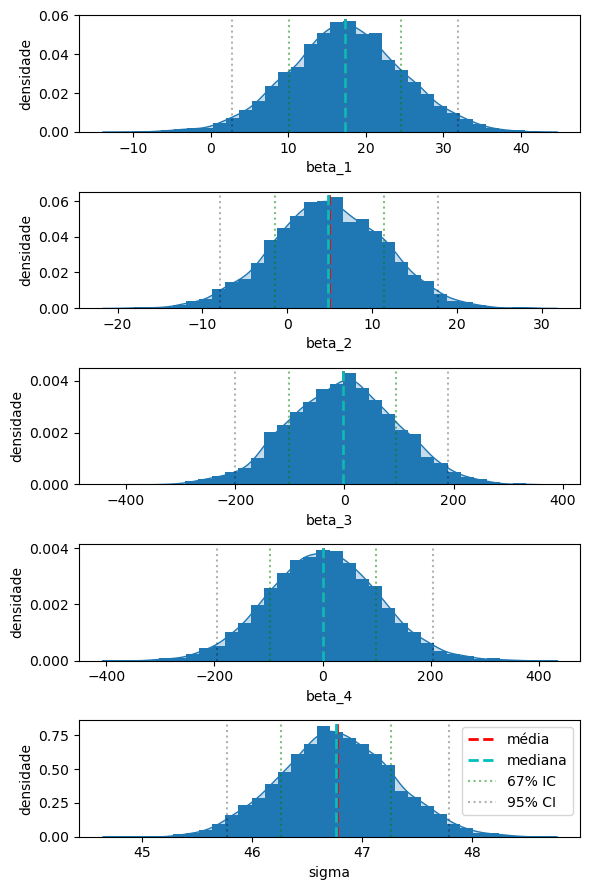

In [12]:
a1 = fit1["beta"][1].reshape(4000,)
b1 = fit1["beta"][2].reshape(4000,)
c1 = fit1["beta"][3].reshape(4000,)
d1 = fit1["beta"][4].reshape(4000,)
e1 = fit1["sigma"].reshape(4000,)


plot_trace(a1, b1, c1, d1, e1, "beta_1", "beta_2", "beta_3", "beta_4", "sigma")

Interpretação dos parâmetros: